# Guided project
## Answering Business Questions using SQL


In [16]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [17]:
def run_query(q):
    '''
    takes a SQL query as an argument and returns a 
    pandas dataframe of that query.
    '''
    with sqlite3.connect('Data/chinook.db') as conn:
        return pd.read_sql(q, conn)

In [18]:
def run_command(c):
    '''
    takes a SQL command as an argument and executes
    it using the sqlite module.
    '''
    with sqlite3.connect('Data/chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [19]:
def show_tables():
    q = '''
    SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
'''
    return run_query(q)

In [20]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [21]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

atp = run_query(albums_to_purchase)

In [22]:
atp

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


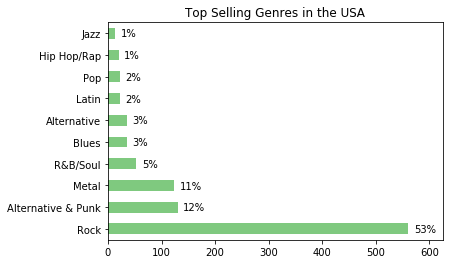

In [23]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, my recommendation is to select the following three albums:

• Red Tone (Punk)  
• Slim Jim Bites (Blues)  
• Meteor and the Girls (Pop)  
  
... and disregard: Regal (Hip-Hop)

In [24]:
most_sales = ''' Select
    e.first_name || " " || e.last_name name,
    e.hire_date hired_since,
    sum(i.total) total_sales,
    COUNT(*) number_of_sales, 
    (ROUND(sum(i.total) / COUNT(*),2)) average_sale_amount,
    (SELECT MAX(i.total) from (
        SELECT 
        MAX(i.total)
        from invoice i
        INNER JOIN customer c ON i.customer_id = c.customer_id
        INNER JOIN employee e ON c.support_rep_id = e.employee_id 
        group by e.employee_id)) largest_sale 
from employee e
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice i on c.customer_id = i.customer_id
GROUP BY 1
ORDER BY 3 DESC
LIMIT 3; '''
run_query(most_sales)

,name,hired_since,total_sales,number_of_sales,average_sale_amount,largest_sale
0,Jane Peacock,2017-04-01 00:00:00,1731.51,212,8.17,23.76
1,Margaret Park,2017-05-03 00:00:00,1584.00,214,7.40,19.80
2,Steve Johnson,2017-10-17 00:00:00,1393.92,188,7.41,16.83


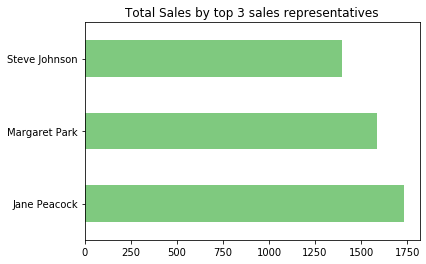

In [25]:
most_sales = run_query(most_sales)
most_sales.set_index("name", inplace=True, drop=True)

most_sales['total_sales'].plot.barh(
    title="Total Sales by top 3 sales representatives",
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

Sales representative <b>Jane Peacock</b> is accountable for the most sales revenue.  
The data gives two explanations for this:  
1) Out of the top 3 she has been working for Chinook the longest  
2) She has the highest average sales revenue per order  

In [26]:
sales_by_country = '''
WITH country_or_other AS (SELECT
       CASE
           WHEN (SELECT count(*) FROM customer where country = c.country) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id )
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC); '''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [27]:
sales_by_country = run_query(sales_by_country)
sales_by_country.set_index("country", inplace=True, drop=True)

In [28]:
sales_by_country

,customers,total_sales,average_order,customer_lifetime_value
country,,,,
USA,13,1040.49,7.942672,80.037692
Canada,8,535.59,7.047237,66.948750
Brazil,5,427.68,7.011148,85.536000
France,5,389.07,7.781400,77.814000
Germany,4,334.62,8.161463,83.655000
Czech Republic,2,273.24,9.108000,136.620000
United Kingdom,3,245.52,8.768571,81.840000
Portugal,2,185.13,6.383793,92.565000
India,2,183.15,8.721429,91.575000


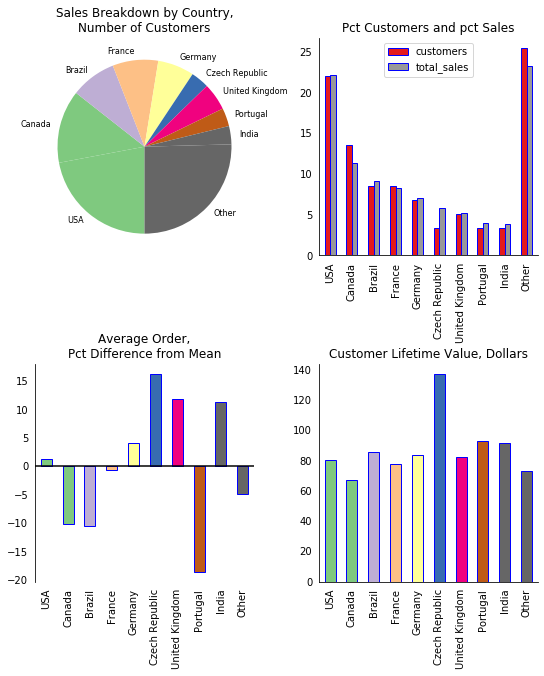

In [29]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sales_by_country.shape[0])]

fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

fig.subplots_adjust(hspace=.5, wspace=.3)

sales_by_country['customers'].plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)
ax1.set_ylabel('')

cust_and_rev_pct = sales_by_country[['customers', 'total_sales']].copy()
cust_and_rev_pct['customers'] = cust_and_rev_pct['customers'] / sum(cust_and_rev_pct['customers']) *100
cust_and_rev_pct['total_sales'] = cust_and_rev_pct['total_sales'] / sum(cust_and_rev_pct['total_sales'])*100

cust_and_rev_pct.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers and pct Sales",
    edgecolor = 'b'
)
ax2.tick_params(top="off", right="off", left="off", bottom="off", color = 'w')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xlabel('')

pct_from_mean = (sales_by_country['average_order'] - sales_by_country['average_order'].mean()) /  sales_by_country['average_order'].mean() * 100
pct_from_mean.plot.bar(
    ax=ax3,
    title="Average Order,\nPct Difference from Mean",
    color=colors,
    edgecolor = 'b'
)
ax3.tick_params(top="off", right="off", left="off", bottom="off", color = 'w')
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.set_xlabel('')

ltv = sales_by_country["customer_lifetime_value"].copy()
ltv.index.name = ''

ltv.plot.bar(
    ax=ax4,
    edgecolor = 'b',
    title="Customer Lifetime Value, Dollars",
    color=colors
)
ax4.tick_params(top="False", right="False", left="False", bottom="False", color = 'w')
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.set_ylabel('')

plt.savefig('Afbeeldingen/four_charts.jpg')

plt.show()
four_charts = Image.open('Afbeeldingen/four_charts.jpg') 

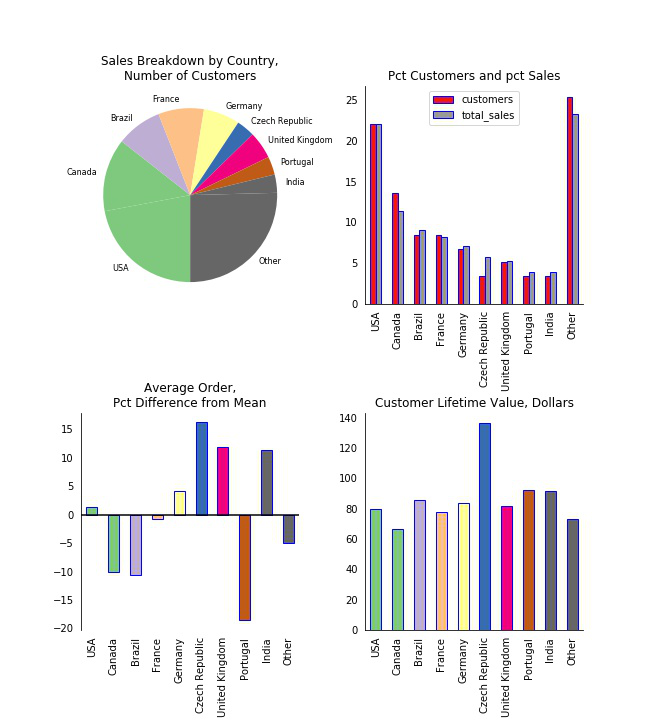

In [30]:
four_charts

Based on the data, there may be opportunity in the following countries:  

• Czech Republic  
• United Kingdom  
• India  


In [31]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6%. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.